In [478]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
import matplotlib

Populating the interactive namespace from numpy and matplotlib


# 1. Read_csv file and EDA & cleaning Data

In [482]:
df_IF= pd.read_csv("industry_found.csv")
df=pd.read_csv("indeed_Company_Salary.csv")

#### Merge two file (indeed data & industry & Founded)

In [483]:
df_IF=df_IF[['company','founded','industry']]

df=df[['company', 'Headquarters_State', 'Headquarters_City', 'revenue',
       'cmp_size', 'salary_sat', 'inter_diff', 'inter_len',
       'title', 'salary', 'salary_unit', 'cmp_rating', 'benefit_rating']]

df_indeed=df.merge(df_IF,on='company',how='left')
print(df_IF.shape, df.shape, df_indeed.shape)

(442, 3) (950, 13) (950, 15)


In [484]:
# Remove the row with too much missing Value

#print(df_indeed[520:535])
#print(df_indeed.Headquarters_State.value_counts())
df_indeed=df_indeed.drop(532) #with missing value

In [485]:
df_indeed['founded_year']=2021-df_indeed['founded']
#df_indeed['founded_year']

In [486]:
df_indeed['salary']=list(map(lambda x: x.replace("US$",''), df_indeed['salary']))
df_indeed['salary']=list(map(lambda x: x.replace("$",''), df_indeed['salary']))
df_indeed['salary']=list(map(lambda x: float(x.replace(",",'')), df_indeed['salary']))
df_indeed.index = [x for x in range(0, len(df_indeed))]

In [490]:
def calculate_salary(i):
    if df_indeed.loc[i,'salary_unit']=='per hour':
        return df_indeed.loc[i,'salary'] * 1789 # avg working hours per week in US:34.4hours 
    elif df_indeed.loc[i,'salary_unit']=='per month':
        return df_indeed.loc[i,'salary'] * 12
    else:
        return df_indeed.loc[i,'salary']

lst=[*range(0,len(df_indeed),1)]
df_indeed['adj_salary']=list(map(calculate_salary,lst))

# 2. Check Nan and replace number if need

In [487]:
print(df_indeed['salary_sat'].isnull().sum()) #0
print(df_indeed['cmp_rating'].isnull().sum()) #0
print(df_indeed['salary'].isnull().sum()) #0
print(df_indeed['benefit_rating'].isnull().sum()) #0
print(df_indeed['founded_year'].isnull().sum()) #4

print(df_indeed['revenue'].value_counts())

print(df_indeed['cmp_size'].isnull().sum())
print(df_indeed['inter_diff'].isnull().sum())
print(df_indeed['inter_len'].isnull().sum())
print(df_indeed['salary_unit'].isnull().sum())

df_indeed.loc[[687,688,689],'founded_year']=19
print(df_indeed['founded_year'].isnull().sum())
df_indeed[df_indeed['revenue'].isnull()]
df_indeed.loc[[470],'revenue']="$500M to $1B (USD)"
df_indeed.loc[[480],'revenue']="$100M to $500M (USD)"
df_indeed.loc[[510],'revenue']="less than $1M (USD)"
df_indeed.loc[[511],'revenue']="less than $1M (USD)"
df_indeed.loc[[690],'revenue']="$100M to $500M (USD)"
df_indeed.loc[[709],'revenue']="$25M to $100M (USD)"
df_indeed[169:171].revenue="more than $10B (USD)"

df_indeed["Headquarters_State"].value_counts()
df_indeed["Headquarters_State"]=list(map(lambda x: x.strip(),df_indeed["Headquarters_State"]))
df_indeed["Headquarters_State"].value_counts()


0
0
0
0
3
more than $10B (USD)    439
$1B to $5B (USD)        145
$5B to $10B (USD)        86
$100M to $500M (USD)     82
$25M to $100M (USD)      72
$500M to $1B (USD)       53
$1M to $5M (USD)         24
$5M to $25M (USD)        21
less than $1M (USD)      19
Anthem, Inc.              2
Name: revenue, dtype: int64
0
0
0
0
0


/Users/yuwenhuang/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


CA                                                                                                                                                                 222
VA                                                                                                                                                                 133
NY                                                                                                                                                                  87
DC                                                                                                                                                                  57
IL                                                                                                                                                                  44
TX                                                                                                                                                                  4

In [488]:
for i in range(len(df_indeed)):
    if 'no' in df_indeed.inter_len[i]:
        df_indeed.loc[[i],'inter_len']='none'

for i in range(len(df_indeed)):
    if 'no' in df_indeed.inter_diff[i]:
        df_indeed.loc[[i],'inter_diff']='none'

### EDA and Setting Up Our Target:

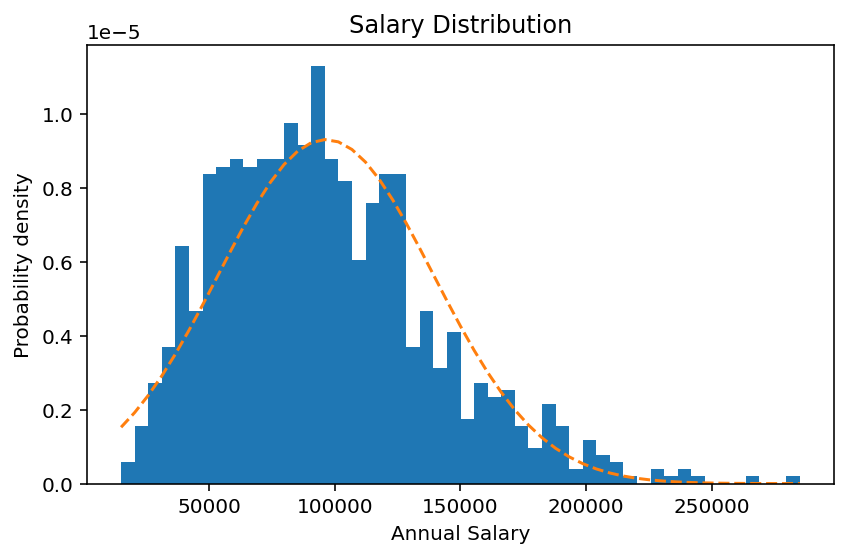

In [491]:
df_indeed.columns
fig, ax = plt.subplots()
n, bins, patches = ax.hist(df_indeed['adj_salary'], 50, density=True)

mu = df_indeed['adj_salary'].mean()  # mean of distribution
sigma = np.std(df_indeed['adj_salary'])  # standard deviation of distribution
x = mu + sigma * np.random.randn(437)
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))

ax.plot(bins, y, '--')
ax.set_xlabel('Annual Salary')
ax.set_ylabel('Probability density')
ax.set_title('Salary Distribution')
fig.tight_layout()
plt.show()

In [492]:
df_indeed["revenue"].value_counts()
#df_indeed[df_indeed.inter_diff=='Difficult'].adj_salary

def revenue1(x):
    if x =='more than $10B (USD)' or x=='$1B to $5B (USD)' or x=='$500M to $1B (USD)':
        return 'high revenue $500M-10B'
    
    elif x =='$500M to $1B (USD)' or x=='$100M to $500M (USD)' or x=='$25M to $100M (USD)':
        return 'Mid revenue $25M-500M'
    
    else:
        return 'low revenue below<$25M'

df_indeed['adj_revenue']=list(map(revenue1, np.array(df_indeed["revenue"])))

df_indeed['adj_revenue'].value_counts()


high revenue $500M-10B    640
Mid revenue $25M-500M     157
low revenue below<$25M    152
Name: adj_revenue, dtype: int64

In [493]:
#fig, ax= plt.subplots()
#ax=sns.boxplot(x="inter_diff", y="adj_salary", data=df_indeed)
#ax=sns.regplot(x="inter_diff", y="adj_salary", data=df_indeed, scatter=False)
#plt.show();

Text(0, 0.5, 'Annual Salary')

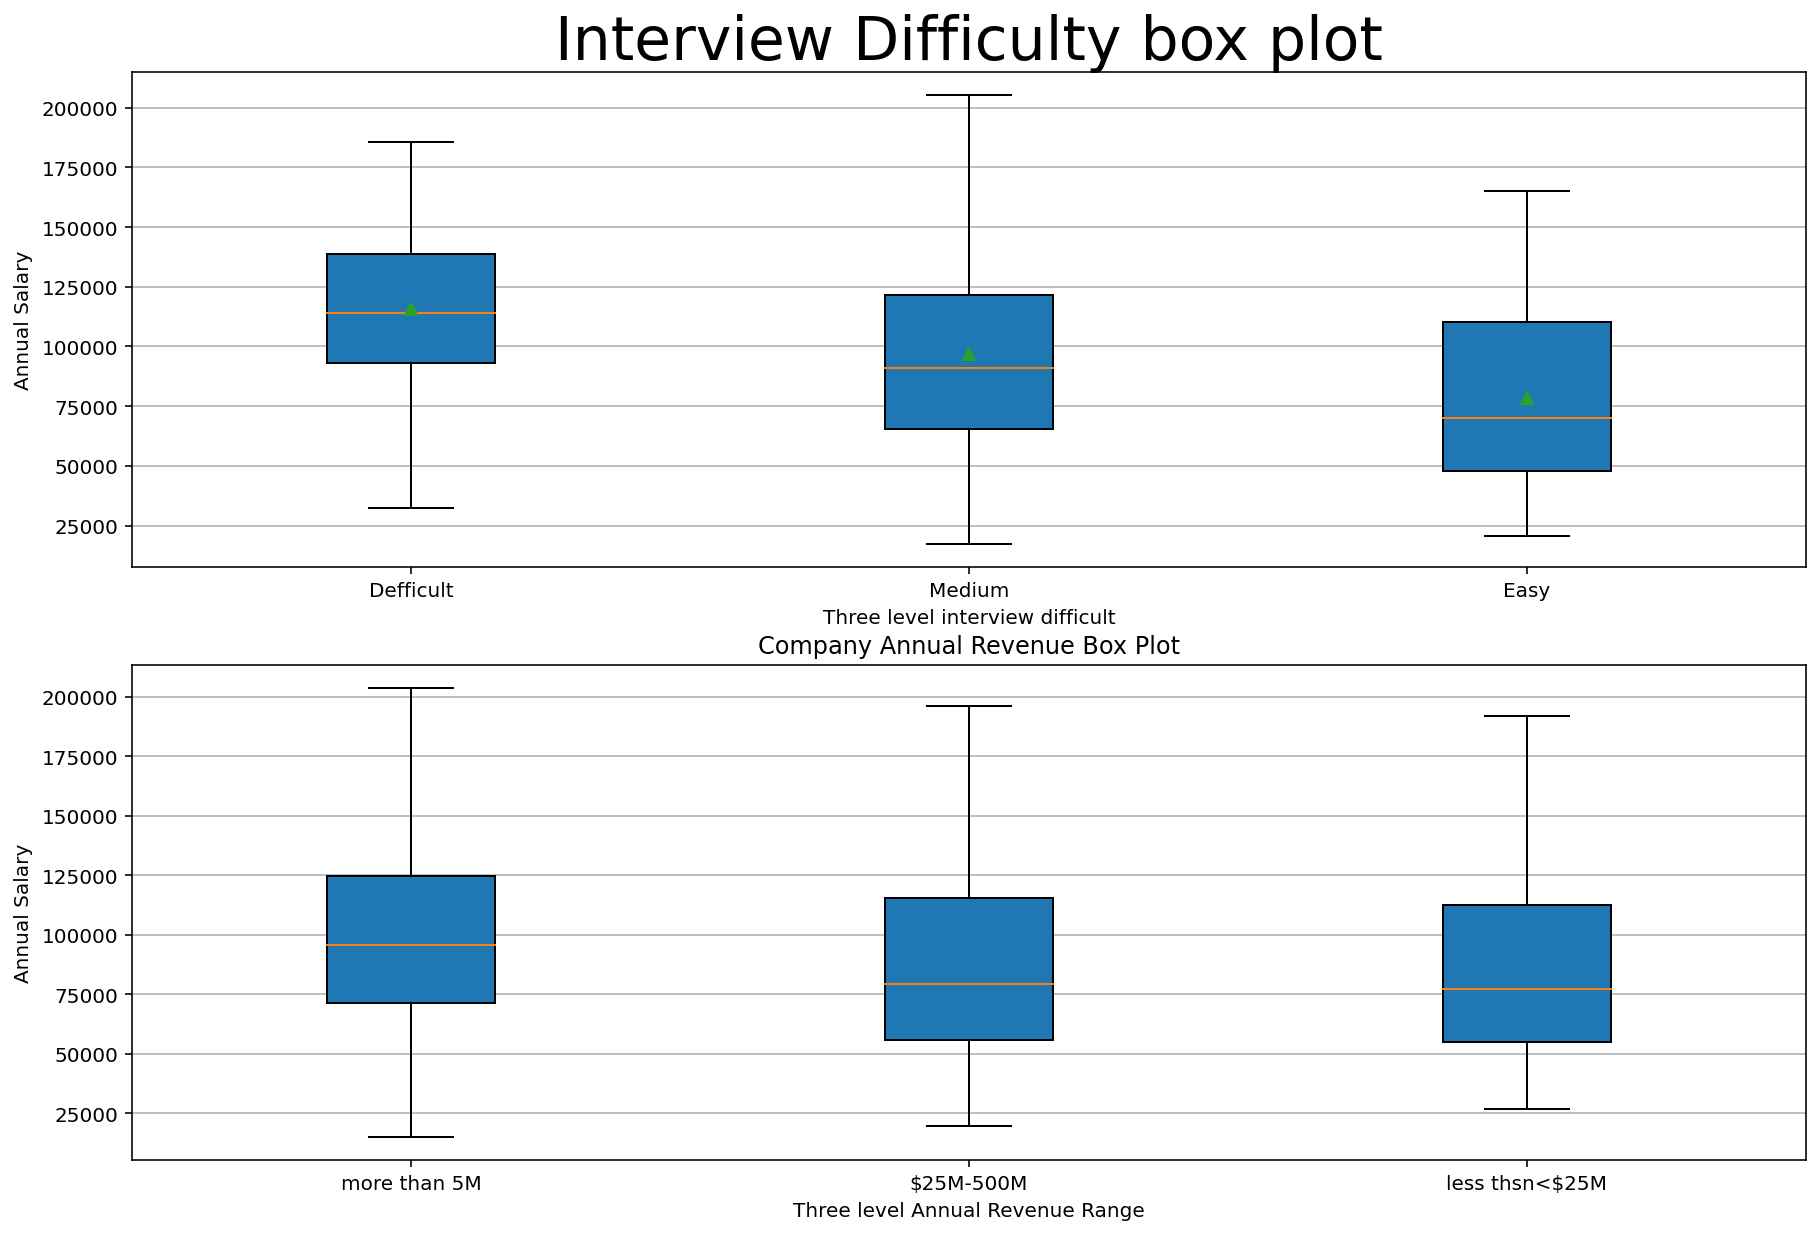

In [494]:
fig, (inter_diff, adj_revenue) = plt.subplots(nrows=2, ncols=1, figsize=(15,10))

bplot1 = inter_diff.boxplot([df_indeed.adj_salary[df_indeed.inter_diff=='Difficult'],
                             df_indeed.adj_salary[df_indeed.inter_diff=='Medium'],
                             df_indeed.adj_salary[df_indeed.inter_diff=='Easy']],
                            vert=True,  # vertical box alignment
                            patch_artist=True,  # fill with color
                            labels=['Defficult','Medium','Easy'],showfliers=False,showmeans=True)  # will be used to label x-ticks

inter_diff.set_title('Interview Difficulty box plot',size=30)

inter_diff.yaxis.grid(True)
inter_diff.set_xlabel('Three level interview difficult')
inter_diff.set_ylabel('Annual Salary')


bplot2 = adj_revenue.boxplot([df_indeed.adj_salary[df_indeed.adj_revenue=='high revenue $500M-10B'],
                            df_indeed.adj_salary[df_indeed.adj_revenue=='Mid revenue $25M-500M'],
                            df_indeed.adj_salary[df_indeed.adj_revenue=='low revenue below<$25M']],
                           vert=True,  # vertical box alignment
                           patch_artist=True,  # fill with color
                           labels=['more than 5M',
                                   '$25M-500M',
                                   'less thsn<$25M'],showfliers=False)  # will be used to label x-ticks

adj_revenue.set_title('Company Annual Revenue Box Plot')
adj_revenue.yaxis.grid(True)
adj_revenue.set_xlabel('Three level Annual Revenue Range')
adj_revenue.set_ylabel('Annual Salary')


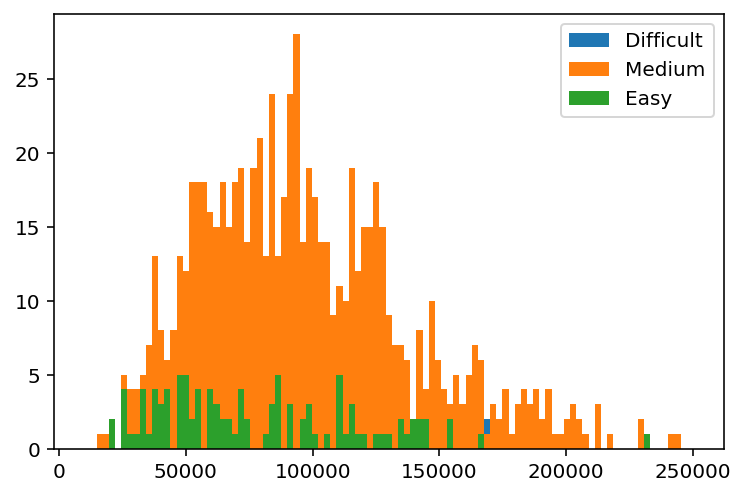

In [496]:
x=df_indeed.adj_salary[df_indeed.inter_diff=='Difficult']
y=df_indeed.adj_salary[df_indeed.inter_diff=='Medium']
z=df_indeed.adj_salary[df_indeed.inter_diff=='Easy']

bins = numpy.linspace(10000, 250000, 100)

pyplot.hist(x, bins, alpha=1, label='Difficult')
pyplot.hist(y, bins, alpha=1, label='Medium')
pyplot.hist(z, bins, alpha=1, label='Easy')
pyplot.legend(loc='upper right')
pyplot.show()

In [429]:
#df_indeed[df_indeed.adj_salary>250000]
#df_indeed=df_indeed.drop([48,109]).reset_index()


# 3. Dummies Variables & OHE
#### df_industry1

In [497]:
#print(df_indeed['industry'].value_counts())
df_industry=pd.get_dummies(df_indeed['industry'])

df_industry1=df_industry.copy()
drop=[]
for i in range(df_industry.shape[1]):
    if df_industry[df_industry.columns[i]].sum()<=15 :
        drop.append(df_industry.columns[i])
        
df_industry1.drop(columns=drop,inplace=True,axis=1)
#df_industry1.head()

#### df_title

In [498]:
df_indeed.head()

df_title=df_indeed[['company','title']]
df_title['title.analyst']=df_title['title'] 

#df_title['title.statistician']=df_title['title']
df_title['title.senior']=df_title['title']
#df_title['title.engineer']=df_title['title']
df_title['title.scientist']=df_title['title']

for i in range(len(df_title)):
    if 'analyst'in df_title['title'][i].lower():
        df_title['title.analyst'][i]= 1
    else:
        df_title['title.analyst'][i]= 0
        
#for i in range(len(df_title)):
#    if 'statistician'in df_title['title'][i].lower():
#        df_title['title.statistician'][i]= 1
#    else:
#        df_title['title.statistician'][i]= 0

for i in range(len(df_title)):
    if 'scientist'in df_title['title'][i].lower():
        df_title['title.scientist'][i]= 1
    else:
        df_title['title.scientist'][i]= 0
        
for i in range(len(df_title)):
    if 'senior'in df_title['title'][i].lower():
        df_title['title.senior'][i]= 1
    else:
        df_title['title.senior'][i]= 0

#for i in range(len(df_title)):
#    if 'engineer'in df_title['title'][i].lower():
#        df_title['title.engineer'][i]= 1
#    else:
#        df_title['title.engineer'][i]= 0

        
#print(df_title['title.analyst'].sum(),
#df_title['title.statistician'].sum(),
#df_title['title.senior'].sum(),
#df_title['title.senior'].sum(),
#df_title['title.engineer'].sum(),
#df_title['title.scientist'].sum())

df_title.drop(columns=["company","title"],inplace=True,axis=1)


<ipython-input-498-aa1e00b75c23>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_title['title.analyst']=df_title['title']
<ipython-input-498-aa1e00b75c23>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_title['title.senior']=df_title['title']
<ipython-input-498-aa1e00b75c23>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [499]:
count=df_indeed['Headquarters_State'].value_counts()
others=list(count[count <= 10].index)
df_indeed['Headquarters_State']=df_indeed['Headquarters_State'].replace(others, 'Other')

In [500]:
OHE_x=df_indeed.loc[:,['Headquarters_State','revenue'#,'cmp_size'
                       ,'inter_diff'
                       , 'inter_len', 'salary_unit']]

#print(df_indeed['revenue'].value_counts())

ohe = OneHotEncoder(drop='first', sparse=False)
ohe.fit(OHE_x)
ohe_all = ohe.transform(OHE_x)
columns = ohe.get_feature_names(['Headquarters_State','revenue'#,'cmp_size'
                                 ,'inter_diff'
                                 , 'inter_len', 'salary_unit'])

ohe_all_df = pd.DataFrame(ohe_all, columns=columns, index=OHE_x.index)

#ohe_all_df

# 4. Linear Regression
#### Target variable & Features

In [501]:
target=df_indeed['adj_salary']

num_df=df_indeed[['salary_sat','cmp_rating','benefit_rating'
                  ,'founded_year']]

feature=pd.concat([df_title,  ohe_all_df], axis=1)
feature=pd.concat([feature, df_industry1], axis=1)
feature=pd.concat([feature, num_df], axis=1)

all_df=pd.concat([df_indeed[['adj_salary']],df_indeed['inter_diff']],axis=1)


all_df


,adj_salary,inter_diff
0,56670.0,Difficult
1,39345.0,Medium
2,107613.0,Medium
3,47204.0,Medium
4,127991.0,Medium
...,...,...
944,125597.0,Medium
945,121255.0,Medium
946,160441.0,Medium
947,240896.0,Medium


In [502]:
X_train_val, X_test, y_train_val, y_test = train_test_split(feature, target, test_size=0.1,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.20, random_state=43)

#X_train  X_train_val  X_test
#y_train  y_train_val  y_test

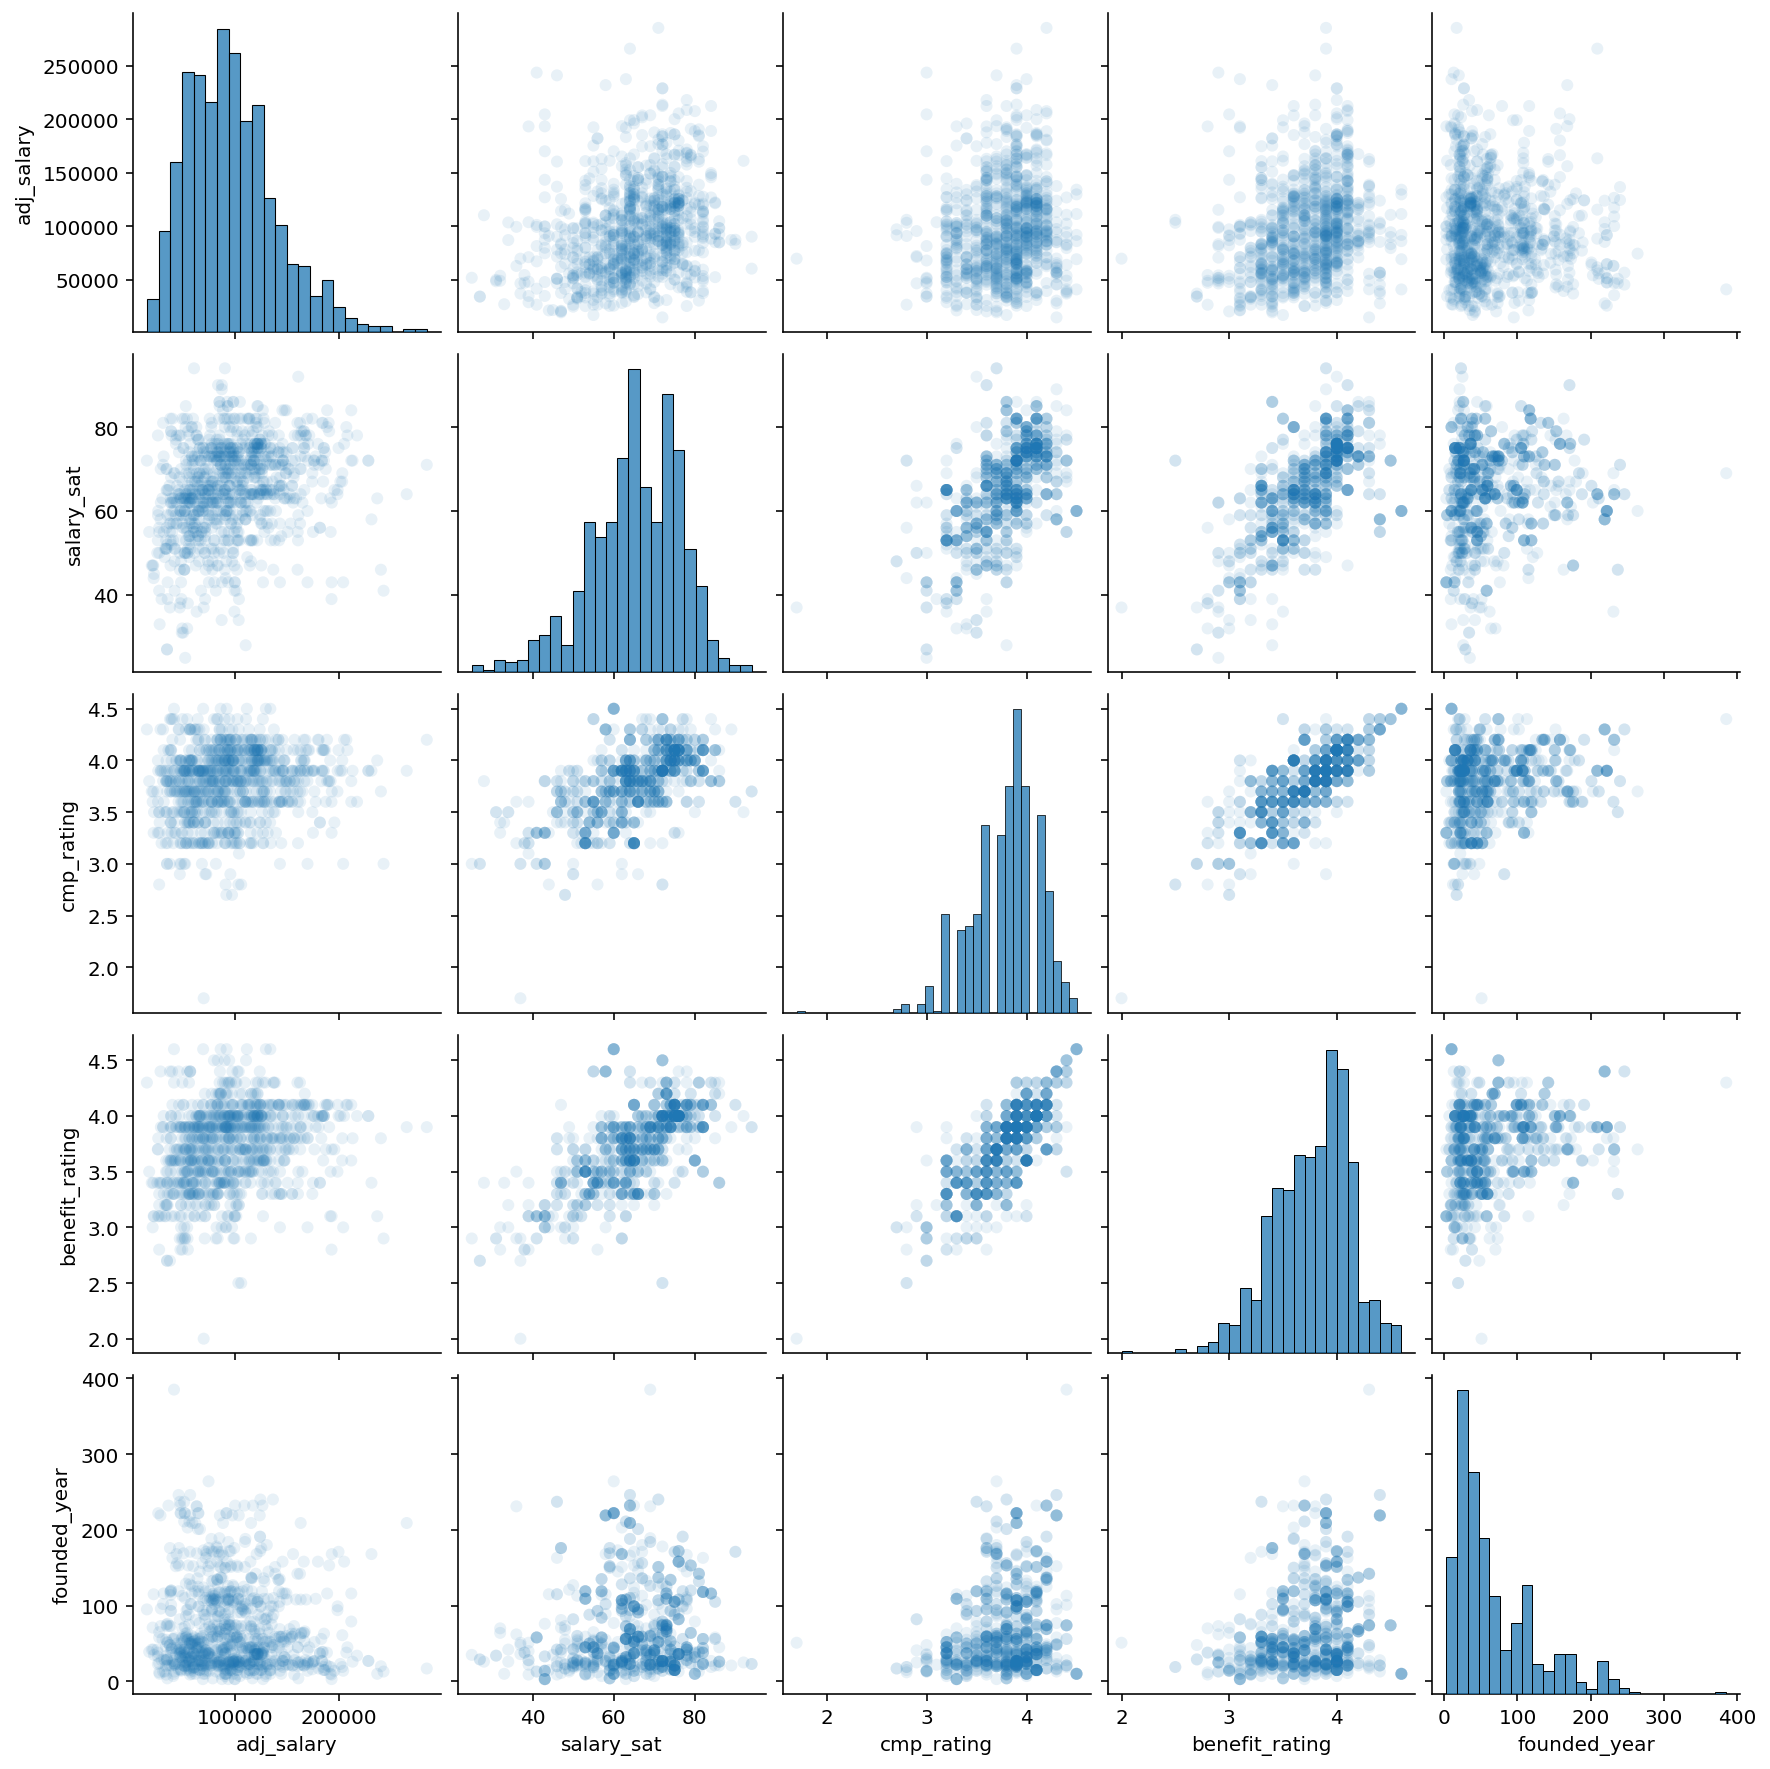

In [503]:
#all_df.info()
#all_df.describe()
num_df1=pd.concat([df_indeed[['adj_salary']],num_df],axis=1)
sns.pairplot(num_df1, plot_kws=dict(alpha=.1, edgecolor='none'))
#sns.pairplot(all_df, plot_kws=dict(alpha=.1, edgecolor='none'))




### split_and_validate

In [504]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data

    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 
        

In [438]:
split_and_validate(X_train_val, y_train_val) #0.5048217834212945


Validation R^2 score was: 0.49180285264419776
Feature coefficient results: 

title.analyst : -30819.31
title.senior : 12348.09
title.scientist : 25667.98
Headquarters_State_CT : -13586.59
Headquarters_State_DC : -7007.88
Headquarters_State_FL : -11416.07
Headquarters_State_GA : -22231.58
Headquarters_State_IL : -22779.96
Headquarters_State_MA : -20229.35
Headquarters_State_MD : -17289.49
Headquarters_State_MN : -19793.80
Headquarters_State_NC : -17221.50
Headquarters_State_NJ : -8375.63
Headquarters_State_NY : -18348.20
Headquarters_State_Other : -16566.75
Headquarters_State_TN : 3695.16
Headquarters_State_TX : -15274.83
Headquarters_State_VA : -6576.11
Headquarters_State_WA : -10033.52
Headquarters_State_WI : -21823.39
revenue_$1B to $5B (USD) : 16573.72
revenue_$1M to $5M (USD) : 20721.93
revenue_$25M to $100M (USD) : 18883.58
revenue_$500M to $1B (USD) : 9626.36
revenue_$5B to $10B (USD) : 13799.08
revenue_$5M to $25M (USD) : 5592.97
revenue_less than $1M (USD) : 6040.43
revenue_mo

### adding polynomial terms

In certain features like 'cmp_rating', 
we notice an slightly upward-curved relationship rather than a simple linear correspondence. 
So I try to transformations for features, 'benefit_rating_SQ','salary_sat','cmp_rating', 'founded_year' to see if we can improve R^2 score.

In [507]:
X_train_val1=X_train_val.copy()
X_train_val1['benefit_rating_SQ']=X_train_val1['benefit_rating']**2
X_train_val1['salary_sat_SQ']=X_train_val1['salary_sat']**2
X_train_val1['cmp_rating_SQ']=X_train_val1['cmp_rating']**2
#X_train_val1['founded_year_log']=np.log(X_train_val1['founded_year'])
#X_train_val1['founded_year_log']=X_train_val1['founded_year']**0.5

split_and_validate(X_train_val1, y_train_val)


Validation R^2 score was: 0.4901872503950664
Feature coefficient results: 

title.analyst : -30810.47
title.senior : 12481.51
title.scientist : 25528.14
Headquarters_State_CT : -12394.20
Headquarters_State_DC : -7658.29
Headquarters_State_FL : -11689.70
Headquarters_State_GA : -22447.76
Headquarters_State_IL : -23048.54
Headquarters_State_MA : -20044.81
Headquarters_State_MD : -17479.19
Headquarters_State_MN : -19835.84
Headquarters_State_NC : -16011.10
Headquarters_State_NJ : -6602.31
Headquarters_State_NY : -18135.99
Headquarters_State_Other : -15863.48
Headquarters_State_TN : 3481.50
Headquarters_State_TX : -15095.28
Headquarters_State_VA : -7614.75
Headquarters_State_WA : -10348.81
Headquarters_State_WI : -19925.14
revenue_$1B to $5B (USD) : 16343.67
revenue_$1M to $5M (USD) : 21577.31
revenue_$25M to $100M (USD) : 19601.43
revenue_$500M to $1B (USD) : 8780.88
revenue_$5B to $10B (USD) : 12700.16
revenue_$5M to $25M (USD) : 4776.95
revenue_less than $1M (USD) : 6047.33
revenue_mor

### adding interaction terms

In [512]:
X_train_val2 = X_train_val1.copy()
#multiplicative interaction
X_train_val2['sat_x_cmp'] = X_train_val2['cmp_rating']* X_train_val2['salary_sat']
X_train_val2['sat_x_bene'] = X_train_val2['benefit_rating']*X_train_val2['salary_sat']
X_train_val2['cmp_x_bene'] = X_train_val2['benefit_rating']*X_train_val2['cmp_rating']  
split_and_validate(X_train_val2, y_train_val)


Validation R^2 score was: 0.4983705449471644
Feature coefficient results: 

title.analyst : -31174.49
title.senior : 12565.51
title.scientist : 25099.73
Headquarters_State_CT : -12032.57
Headquarters_State_DC : -5870.43
Headquarters_State_FL : -9535.64
Headquarters_State_GA : -22218.31
Headquarters_State_IL : -22778.78
Headquarters_State_MA : -19533.40
Headquarters_State_MD : -15985.97
Headquarters_State_MN : -18158.96
Headquarters_State_NC : -15582.48
Headquarters_State_NJ : -5483.23
Headquarters_State_NY : -17813.75
Headquarters_State_Other : -15741.01
Headquarters_State_TN : 5501.80
Headquarters_State_TX : -14828.17
Headquarters_State_VA : -6446.62
Headquarters_State_WA : -8727.43
Headquarters_State_WI : -23445.82
revenue_$1B to $5B (USD) : 17134.12
revenue_$1M to $5M (USD) : 22538.34
revenue_$25M to $100M (USD) : 19110.65
revenue_$500M to $1B (USD) : 9978.66
revenue_$5B to $10B (USD) : 13165.22
revenue_$5M to $25M (USD) : 6373.03
revenue_less than $1M (USD) : 3607.36
revenue_more 

### PolynomialFeatures

R^2 is high, however, there is overfit issue

In [514]:
poly=PolynomialFeatures(2,interaction_only=True)
X_train_val3=poly.fit_transform(X_train_val)
lr=LinearRegression()
lr.fit(X_train_val3, y_train_val)
print(lr.score(X_train_val3, y_train_val)) 

0.9009141816183525


In [515]:
pd.DataFrame(feature).columns

Index(['title.analyst', 'title.senior', 'title.scientist',
       'Headquarters_State_CT', 'Headquarters_State_DC',
       'Headquarters_State_FL', 'Headquarters_State_GA',
       'Headquarters_State_IL', 'Headquarters_State_MA',
       'Headquarters_State_MD', 'Headquarters_State_MN',
       'Headquarters_State_NC', 'Headquarters_State_NJ',
       'Headquarters_State_NY', 'Headquarters_State_Other',
       'Headquarters_State_TN', 'Headquarters_State_TX',
       'Headquarters_State_VA', 'Headquarters_State_WA',
       'Headquarters_State_WI', 'revenue_$1B to $5B (USD)',
       'revenue_$1M to $5M (USD)', 'revenue_$25M to $100M (USD)',
       'revenue_$500M to $1B (USD)', 'revenue_$5B to $10B (USD)',
       'revenue_$5M to $25M (USD)', 'revenue_less than $1M (USD)',
       'revenue_more than $10B (USD)', 'inter_diff_Easy', 'inter_diff_Medium',
       'inter_diff_none', 'inter_len_About a month', 'inter_len_About a week',
       'inter_len_About two weeks', 'inter_len_More than one mont

##### Split out training data & testing data

# 5. LASSO Regularization

In [575]:
X_train_val, X_test, y_train_val, y_test = train_test_split(feature, target, test_size=0.1,random_state=42)

p = PolynomialFeatures(degree=2,interaction_only=False)
X_train_val= p.fit_transform(X_train_val)
X_test= p.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.20, random_state=42)

s = StandardScaler(with_mean=True)
X_train_poly_scaled = s.fit_transform(X_train)
X_val_poly_scaled = s.fit_transform(X_val)
#X_test_poly_scaled=s.fit_transform(X_test)


#p = PolynomialFeatures(degree=2,interaction_only=False)
#X_train_val= p.fit_transform(X_train_val)
#X_test= p.transform(X_test)
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.20, random_state=42)



In [585]:
m = LassoCV(cv=3)
#p = PolynomialFeatures(degree=2,interaction_only=True)
#X_train_poly = p.fit_transform(X_train_val)
#s = StandardScaler(with_mean=False)
#X_train_poly_scaled = s.fit_transform(X_train_val)


#m.fit(X_train_poly_scaled, y_train)
#print(m.score(X_val_poly_scaled, y_val))
#print(m.alpha_) #46557

#s = StandardScaler(with_mean=False)
#X_train_poly_scaled = s.fit_transform(X_train_val)

m.fit(X_train,y_train)
print(m.score(X_val,y_val))
print(m.alpha_)

lasso_model = Lasso(alpha = 50)
lasso_model.fit(X_train, y_train)
lasso_model.score(X_val, y_val)#0.54

0.37328772527883136
46940.777883110066


/Users/yuwenhuang/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177129944226.97852, tolerance: 127748217.9175844
  model = cd_fast.enet_coordinate_descent(


0.576872760625003

In [586]:
col=p.get_feature_names(['title.analyst', 'title.statistician', 'title.senior', 'title.engineer',
       'title.scientist', 'Headquarters_State_CT', 'Headquarters_State_DC',
       'Headquarters_State_FL', 'Headquarters_State_GA',
       'Headquarters_State_IL', 'Headquarters_State_MA',
       'Headquarters_State_MD', 'Headquarters_State_MN',
       'Headquarters_State_NC', 'Headquarters_State_NJ',
       'Headquarters_State_NY', 'Headquarters_State_Other',
       'Headquarters_State_TN', 'Headquarters_State_TX',
       'Headquarters_State_VA', 'Headquarters_State_WA',
       'Headquarters_State_WI', 'revenue_$1B to $5B (USD)',
       'revenue_$1M to $5M (USD)', 'revenue_$25M to $100M (USD)',
       'revenue_$500M to $1B (USD)', 'revenue_$5B to $10B (USD)',
       'revenue_$5M to $25M (USD)', 'revenue_less than $1M (USD)',
       'revenue_more than $10B (USD)', 'cmp_size_10,000', 'cmp_size_11 to 50',
       'cmp_size_2 to 10', 'cmp_size_201 to 500', 'cmp_size_5,001 to 10,000',
       'cmp_size_501 to 1,000', 'cmp_size_51 to 200', 'inter_diff_Easy',
       'inter_diff_Medium', 'inter_diff_none', 'inter_len_About a month',
       'inter_len_About a week', 'inter_len_About two weeks',
       'inter_len_More than one month', 'inter_len_none',
       'salary_unit_per month', 'salary_unit_per year', 'Aerospace & Defense',
       'Education', 'Energy, Mining & Utilities', 'Financial Services',
       'Government & Public Administration', 'Healthcare',
       'Human Resources & Staffing', 'Information Technology', 'Insurance',
       'Manufacturing', 'Pharmaceutical & Biotechnology', 'Retail & Wholesale',
       'Telecommunications', 'salary_sat', 'cmp_rating', 'benefit_rating',
       'founded_year'])

list(zip(col, lasso_model.coef_))

for i in range(len(list(lasso_model.coef_))):
    if lasso_model.coef_[i] != 0.0:
        print (col[i],': ',lasso_model.coef_[i])


Government & Public Administration :  744.26559275111
Information Technology :  -1.7788463017420164
title.analyst title.statistician :  5998.525643354464
title.analyst title.scientist :  11814.427450983567
title.analyst Headquarters_State_FL :  1743.0202561377537
title.analyst Headquarters_State_GA :  2446.500590856198
title.analyst Headquarters_State_MA :  14052.980892227877
title.analyst Headquarters_State_MN :  -20600.4617361488
title.analyst Headquarters_State_NC :  -28646.24286218522
title.analyst Headquarters_State_Other :  10516.771743874213
title.analyst Headquarters_State_TN :  4501.582431408595
title.analyst Headquarters_State_WI :  14835.394280530438
title.analyst revenue_$1M to $5M (USD) :  5532.3651154946765
title.analyst revenue_$25M to $100M (USD) :  -7721.075101540831
title.analyst revenue_less than $1M (USD) :  -2631.7703390972324
title.analyst revenue_more than $10B (USD) :  8479.200270189456
title.analyst cmp_size_2 to 10 :  42.23807773688616
title.analyst cmp_size_2

Text(0.5, 0, 'Predicted salary $')

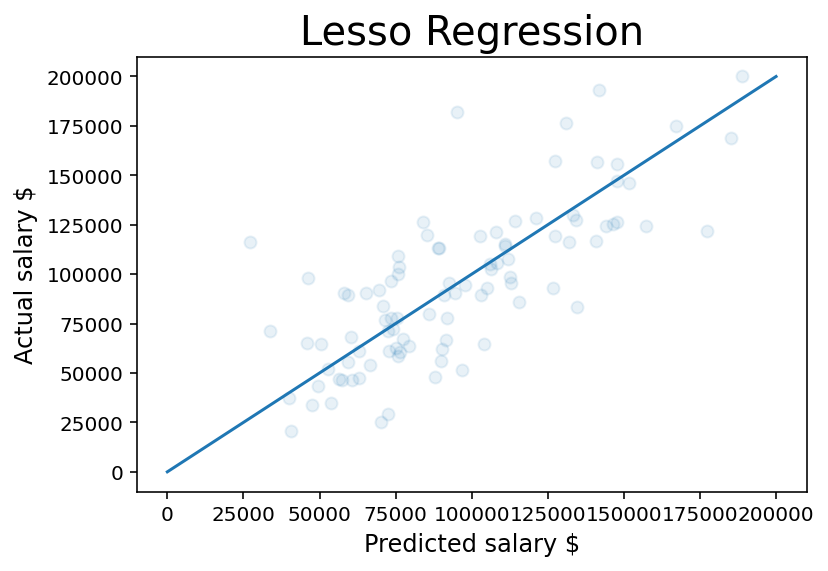

In [587]:
test_set_pred = lasso_model.predict(X_test)
plt.scatter(test_set_pred, y_test, alpha=.1)


plt.plot(np.linspace(0,200000,1000), np.linspace(0,200000,1000))
plt.title("Lesso Regression",size=20)
plt.ylabel("Actual salary $",size=12)
plt.xlabel("Predicted salary $",size=12)

#### r-squared
r2_score(y_test, test_set_pred)

In [588]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

19629.788923451448

# 6. Ridge Regularization

In [580]:
m = RidgeCV(cv=3)
#p = PolynomialFeatures(degree=2,interaction_only=True)
#X_train_poly_R = p.fit_transform(X_train_val)

s = StandardScaler(with_mean=False)
X_train_poly_scaled = s.fit_transform(X_train_val)

m.fit(X_train_poly_scaled,y_train_val)
m.score(X_train_poly_scaled,y_train_val)
m.alpha_


10.0

In [590]:
ridge_model = Ridge(alpha = 10)
ridge_model.fit(X_train, y_train)
ridge_model.score(X_val, y_val) #0.6468


0.6004078813666989

#### Final Model create by train + Validation data

In [591]:
ridge_model = Ridge(alpha = 10)
ridge_model.fit(X_train_val, y_train_val)
ridge_model.score(X_test, y_test)

0.6468284784689164

Text(0.5, 0, 'Predicted salary $')

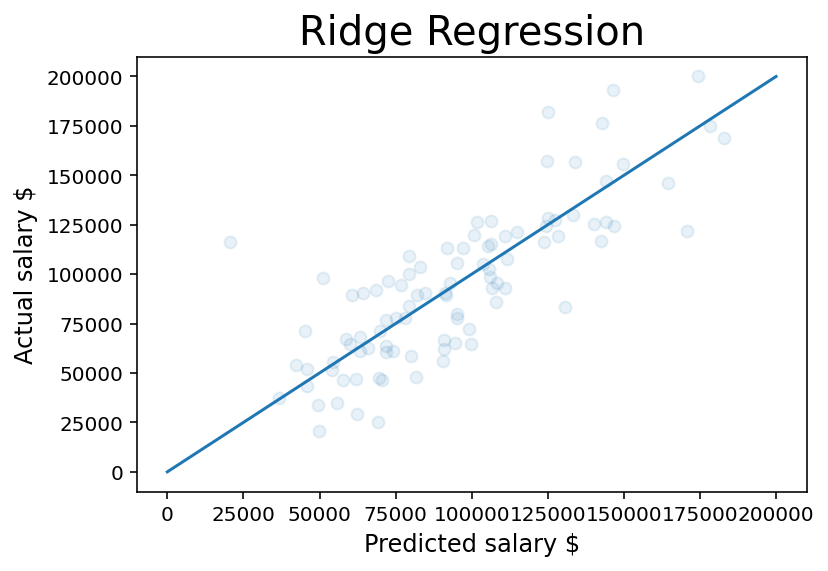

In [592]:
test_set_pred = ridge_model.predict(X_test)
plt.scatter(test_set_pred, y_test, alpha=.1)
plt.plot(np.linspace(0,200000,1000), np.linspace(0,200000,1000))
plt.title("Ridge Regression",size=20)
plt.ylabel("Actual salary $",size=12)
plt.xlabel("Predicted salary $",size=12)

In [593]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

17332.18899345001

In [594]:
col=['title.analyst', 'title.senior', 'title.scientist',
     'Headquarters_State_CT', 'Headquarters_State_DC',
       'Headquarters_State_FL', 'Headquarters_State_GA',
       'Headquarters_State_IL', 'Headquarters_State_MA',
       'Headquarters_State_MD', 'Headquarters_State_MN',
       'Headquarters_State_NC', 'Headquarters_State_NJ',
       'Headquarters_State_NY', 'Headquarters_State_Other',
       'Headquarters_State_TN', 'Headquarters_State_TX',
       'Headquarters_State_VA', 'Headquarters_State_WA',
       'Headquarters_State_WI', 'revenue_$1B to $5B (USD)',
       'revenue_$1M to $5M (USD)', 'revenue_$25M to $100M (USD)',
       'revenue_$500M to $1B (USD)', 'revenue_$5B to $10B (USD)',
       'revenue_$5M to $25M (USD)', 'revenue_less than $1M (USD)',
       'revenue_more than $10B (USD)', 'inter_diff_Easy', 'inter_diff_Medium',
       'inter_diff_none', 'inter_len_About a month', 'inter_len_About a week',
       'inter_len_About two weeks', 'inter_len_More than one month',
       'inter_len_none', 'salary_unit_per month', 'salary_unit_per year',
       'Aerospace & Defense', 'Education', 'Energy, Mining & Utilities',
       'Financial Services', 'Government & Public Administration',
       'Healthcare', 'Human Resources & Staffing', 'Information Technology',
       'Insurance', 'Manufacturing', 'Pharmaceutical & Biotechnology',
       'Retail & Wholesale', 'Telecommunications', 'salary_sat',
       'founded_year']

list(zip(col, ridge_model.coef_))

[('title.analyst', 0.0),
 ('title.senior', -2342.4452556178767),
 ('title.scientist', -455.574404581781),
 ('Headquarters_State_CT', 4000.3473832489126),
 ('Headquarters_State_DC', 247.0772061799222),
 ('Headquarters_State_FL', 774.2581414615388),
 ('Headquarters_State_GA', 26.497662530739035),
 ('Headquarters_State_IL', -709.9185527732943),
 ('Headquarters_State_MA', -366.4808141153226),
 ('Headquarters_State_MD', -332.5309375094048),
 ('Headquarters_State_MN', 398.3967729376259),
 ('Headquarters_State_NC', -611.3288966863508),
 ('Headquarters_State_NJ', 888.5070992133287),
 ('Headquarters_State_NY', -957.5478394869951),
 ('Headquarters_State_Other', -284.0722861392396),
 ('Headquarters_State_TN', 78.01719479033454),
 ('Headquarters_State_TX', 39.87757452469771),
 ('Headquarters_State_VA', 437.8958168080908),
 ('Headquarters_State_WA', 2144.191095431903),
 ('Headquarters_State_WI', 753.1781235819421),
 ('revenue_$1B to $5B (USD)', 611.6806227821439),
 ('revenue_$1M to $5M (USD)', -238

# 7. Linear Regression Assumption

In [595]:
import pandas as pd
import numpy as np
import seaborn as sns
import patsy
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline